<h1><center>DALLAS CRIME DATA</center></h1>
<h2><center>MSDS 7331 Mini Project</center></h2>
<h2><center>SVM and Logistic Regression Modeling</center></h2>

<h4><center>Team Members</center></h4>

           Yejur Singh Kunwar           Bin Yu               Vivek Viswanathan          Kevin Mendonsa
              Dallas, TX               Dallas, TX               Dallas, TX                Irvine, CA

## Introduction
##### Data Description
The Dallas Crime Incident data set that is used in the Mini Project acts as a bridge between the citizens of Dallas and the Dallas PD. It represents the Dallas Police Public Data - RMS Incidents from June 1, 2014 to September 7, 2018. 
For purposes of this Mini Project, the main dataframe that is trimmed based on the analysis performed as part of Lab 1. The details of the data quality clean up and choice of columns have been detailed in the Lab 1 notebook link provided below.

The data set currently has 254,091 rows and 44 columns.

**Lab 1 Notebook Link -** https://github.com/wtubin/MSDS7331-Data-Mining/MSDS7331_Data_Mining_Lab1_Data-Viz_Pre-Processing.ipynb
**Note -** The structure of the document will closely follow the phases of the CRISP-DM Modeling Phase.

##### Objective

The objective of this unit is to perform Logistic Regression and Support Vector Machines categorization on the chosen data set and optimize the parameters in order to improve the accuracy of the model. Our goal of this lab is trying to clasify the arrest taken in each incident call based on the selected features in the dataset.

**GitHub Repository containing the artifacts -** https://github.com/wtubin/MSDS7331-Data-Mining

**Location of the raw (compressed) data file -** https://github.com/wtubin/MSDS7331-Data-Mining/Police_Incidents.7z 

As part of this analysis, we are attempting to train and test our classification model 5 different ways using 3 modeling techniques. The details are provided below.

The EvaluateClassifierEstimator function from Dr. Drew's NC Education project GitHub has been modified so as to output Accuracy, Precision, and Recall. We'll use these parameters to evaluate the effectiveness of our model.

# Create Models


### Modeling Technique
We will be exploring the following modeling techniques as part of our classification
 * Logistic Regression, using GridSearchCV, with Manual Feature reduction
 * Logistic Regression, using GridSearchCV, with Recursive Feature Elimination (RFE)
 * Support Vector Machine (SVM)

### Modeling Assumptions
For purposes of our modeling, we have performed the following transformations to ensure:
 * All features are uniformly distributed with 0 mean and unit standard deviation
 * Features are scaled to ensure that one of the features does not have more emphasis than another
 * Multi-colinearity has been removed
 * Features have been converted to categories to improve model efficiency.

### Data Preparation

The dataset is loaded into the workspace as a data frame and undergoes transformation or standardization before being fed into model. The attributes with zero variance (closer) or those attributes that does not have value in predicting the respose variable are removed. For example attributes like beats, sector, Location1, etc. serves no purpose for our model. 

Once the unwanted attributes are removed, we're left with attributes that can contribute to our model. Since these attributes will help us classify the Response, going forward, we will refer to the Explanatory variables as Features.

Then dataset is split into explanatory, referred to as inci_X (Features) and response referred to as inci_Y (response: "Arrest_status") for running the models.

        - inci_X : Explanatory variables (Features)
        - inci_Y : Response variable (Arrest_status)

The Features are being scaled to have a mean of 0 and variance of 1 in order to imporve accuracy of the classification models. The data will then be split into 80/20 training/test set. To reduce possibility of "overfitting", 10-fold cross validation is being implemented. The GridSearchCV method helps the model search over specified parameters and identify the optimal parameters for model execution. Correlation scores, variance inflaion scores, variance inflation factors (VIFs) and significance will be utilized for manual determination of Features. This will help with feature reduction or feature selection for our final model. The remaining features will also be utilized in other two models: Logistic Regression using GridSearchCV with Recursive Feature Elimination (RFECU) and Support Vector Machine (SVM). The scikit-learn GridSearchCV method will be utilized to adjust model parameters.

The following techniques have been used during the analysis to improve the performance and accuracy.
 - Class balancing using down sampling
 - Removing Multicolinearity by reviewing correlation matrix
 - Removing Multicolinearity by reviewing VIF
 - Scaling the features
 - 10 fold cross validation
 
A brief description of the purpose and outcome of each of the techniques is explained as they are being applied to the data set.

**Note:** As part of Lab 1, we had chosen a continous variable (Response Time) as our Response Variable. However, after viewing class videos and additional reading, the project team decided to change to response variable to Arrest Status because we'd be classifying an outcome that has a binary response.

In [49]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt
import plotly.tools as tls

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline

In [50]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = "../../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)

In [51]:
# Exploying the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
incident = incident[incident['Call_Received_Hour'].isnull()==False]
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

# Print out the data properties
print(incident.shape)
print('Number of null columns and their counts')
print(incident_NullCols)

(254091, 44)
Number of null columns and their counts
Type_Location                4856
Reporting_Area                155
Beat                           70
Sector                         70
Call_Cleared_Date_Time        165
Call_Dispatch_Date_Time        21
Offense_Status                557
Victim_Condition           233793
Family_Offense                 32
Weapon_Used                 28804
UCR_Offense_Name            14475
UCR_Code                    14475
X_Coordinate                21095
Y_Coordinate                21095
State                         608
Call_Cleared                  165
Call_Dispatch                  21
Latitude                     9755
Longitude                    9755
dtype: int64


The dataset has 254,091 rows and 44 attributes. Among these 44 attributes, there are 19 attributes have missing value.

In [52]:
# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]

In [53]:
# Further data clean up on the feature variables

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [54]:
# Change norminal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)
# coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes

In [55]:
incident.columns

Index(['Year_of_Incident', 'Service_Number_ID', 'Watch', 'Type_of_Incident',
       'Type_Location', 'Reporting_Area', 'Beat', 'Division', 'Sector',
       'Council_District', 'Day1_of_the_Week', 'Call_Received_Date_Time',
       'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time',
       'Person_Involvement_Type', 'Victim_Type', 'Victim_Race',
       'Victim_Gender', 'Victim_Age', 'Offense_Status', 'Victim_Condition',
       'Hate_Crime', 'Family_Offense', 'Weapon_Used', 'Gang_Related_Offense',
       'Drug_Related', 'UCR_Offense_Name', 'RMS_Code', 'UCR_Code',
       'X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
       'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch',
       'Number_of_offense', 'Response_time', 'Latitude', 'Longitude',
       'Arrest_status', 'Call_Received_Hour', 'IsMale', 'Social_crime_score'],
      dtype='object')

In [56]:
incident = incident.drop(['Year_of_Incident', 'Service_Number_ID', 'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District','Call_Received_Date_Time',
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 
                          'Victim_Gender', 'Offense_Status', 'Victim_Condition','Family_Offense', 'Weapon_Used', 
                          'RMS_Code', 'UCR_Code','X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
                          'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch','Latitude', 'Longitude'],axis=1)

In [57]:
incident.sample(2)

,Watch,Division,Day1_of_the_Week,Victim_Type,Victim_Race,Victim_Age,Hate_Crime,Gang_Related_Offense,Drug_Related,UCR_Offense_Name,Number_of_offense,Response_time,Arrest_status,Call_Received_Hour,IsMale,Social_crime_score
89442,1,0,6,2,6,26,0,0,0,5,1,4,0,12.0,1,0
191677,1,2,1,2,2,35,0,0,0,5,1,64,0,8.0,1,0


### Response Variable Analysis

As part of this analysis, we look at the distinct values and distribution of the response variable. 

Class 0: 202337
Class 1: 23115
Proportion: 8.75 : 1


<Figure size 576x360 with 0 Axes>

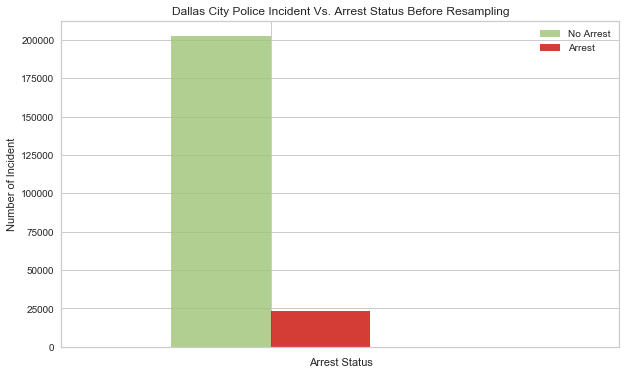

In [58]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Draw bar plot

# data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

### Resampling (Downsampling) the data set

Based on the above analysis, we have almost 10 times the number of samples for perpetrator not being arrested compared to where an arrest is made. 

In an imbalanced class, we cannot reliably use accuracy to measure performance. This makes training the model very tricky. The model may predict the majority class better and sometimes ignore the minority class completely. There are 2 ways to blanace the data set: downsampling and upsampling. We selected the downsampling as we have a big dataset. It will run long time in SVM if we choose upsampling method.

We perform down-sample by 
1. Separating observations based on class
2. Resample the majority class without replacement after setting the number of samples to match the minorit class count
3. Combine the down-sampled majority class and the original minority class

Finally, we plot the distribution of distinct classes of the response variable to check that it is balanced before proceeding with further analysis.

Source: https://elitedatascience.com/imbalanced-classes

In [59]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=23115,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()

1    23115
0    23115
Name: Arrest_status, dtype: int64

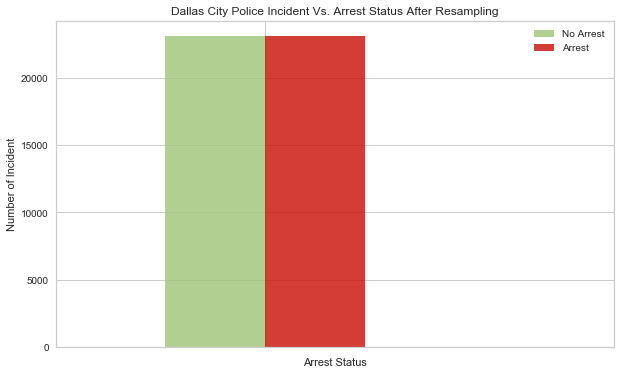

In [60]:
n_groups = 1
NoArrest=df_downsampled.Arrest_status.value_counts()[0]
Arrest=df_downsampled.Arrest_status.value_counts()[1]
 
# create plot
#ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()


 After downsampling, class 0 (No Arrest) has the same size as the classe 1 (Arrest). 

In [61]:
# copy the down sampling dataset to original incident data frame and continue the anl
incident= df_downsampled.copy()

### Collinearity

During Lab 1 data exploration, the team identified the attributes in the original dataset to have multicollinearity. In other words, one predictor variable in the regression model can be linearly predicted from the others with a substantial degree of accuracy.

During this Mini Lab exercise, some additional collinearity was introduced because:
 * Continous Variables were converted to Categorical variables (e.g.: Response Time & Victim Age are converted to Categorical)
 * Derived Features based on (or a combination of) values of existing features (e.g.: Social Crime Score)
 * Identical features where one was a roll up of the other (e.g.: Watch & Call Received Hour)
 
Based on the analysis of Correlation Matrix, we would be dropping one of the columns from the pair that are highly correlated.

In [62]:
#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Social_crime_score  Drug_Related            0.842685
Call_Received_Hour  Watch                   0.712316
Social_crime_score  Gang_Related_Offense    0.562247
                    Hate_Crime              0.152233
Victim_Race         UCR_Offense_Name        0.131186
                                              ...   
Arrest_status       Victim_Race            -0.071456
UCR_Offense_Name    Watch                  -0.103933
Response_time       Arrest_status          -0.174816
Victim_Race         Division               -0.286416
UCR_Offense_Name    Arrest_status          -0.310592
Length: 120, dtype: float64


In [63]:

#Drop highly correlated, insignificant and high VIF columns.
incident = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime'], axis=1)

#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Victim_Race         UCR_Offense_Name     0.131186
Social_crime_score  Number_of_offense    0.110633
Victim_Race         Victim_Age           0.106044
Number_of_offense   Arrest_status        0.081587
UCR_Offense_Name    Response_time        0.072490
                                           ...   
Arrest_status       Victim_Age          -0.067700
Victim_Race         Arrest_status       -0.071456
Arrest_status       Response_time       -0.174816
Division            Victim_Race         -0.286416
Arrest_status       UCR_Offense_Name    -0.310592
Length: 66, dtype: float64


In [64]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']

# Features with no predictive features with respect to resposne variable
incident = incident.drop(['Arrest_status'],axis=1)


In [65]:
# Create inci_X Explanatory Variables DF to support the individual models
inci_X = incident.drop(['Day1_of_the_Week', 'Victim_Race'], axis=1)
inci_X_Rfe = incident
inci_X_SVM = incident
print("inci_X", inci_X.info())
print("inci_X_Rfe", inci_X_Rfe.info())
print("inci_X_SVM", inci_X_SVM.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46230 entries, 72724 to 255143
Data columns (total 9 columns):
Division              46230 non-null int8
Victim_Type           46230 non-null int8
Victim_Age            46230 non-null int32
UCR_Offense_Name      46230 non-null int8
Number_of_offense     46230 non-null int32
Response_time         46230 non-null int32
Call_Received_Hour    46230 non-null float64
IsMale                46230 non-null int32
Social_crime_score    46230 non-null int64
dtypes: float64(1), int32(4), int64(1), int8(3)
memory usage: 1.9 MB
inci_X None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46230 entries, 72724 to 255143
Data columns (total 11 columns):
Division              46230 non-null int8
Day1_of_the_Week      46230 non-null int8
Victim_Type           46230 non-null int8
Victim_Race           46230 non-null int8
Victim_Age            46230 non-null int32
UCR_Offense_Name      46230 non-null int8
Number_of_offense     46230 non-null int32
Response_t

### Scale Data

In order to improve accuracy and performance of our classification model and to prevent emphasis of one feature over the other, features are scaled to have a mean of 0 and variance of 1 for all models in this mini project. 

In [66]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
inci_X_scaled = scaler.fit_transform(inci_X)
inci_X_Rfe_scaled = scaler.fit_transform(inci_X_Rfe)
inci_X_SVM_scaled = scaler.fit_transform(inci_X_SVM)

#Save as data frames
df_inci_X_scaled = pd.DataFrame(inci_X_scaled)
df_inci_X_Rfe_scaled = pd.DataFrame(inci_X_Rfe_scaled)
df_inci_X_SVM_scaled= pd.DataFrame(inci_X_SVM_scaled)

### Variance Inflation Factors (VIF)

Yet another way of identifying the multicollinearity is by checking the Variance Inflation Factors. When the multicollinearity exists, the standard errors and thereby the variances of the estimated coefficients are inflated. 

In general, a VIF values of under 10 helps create a better model. 

Credit: https://onlinecourses.science.psu.edu/stat501/node/347/

Let's look at the **VIF values of the features before and after scaling function**. This provides us a better understanding of how the scaling methodology helped standardize the feature values.

In [67]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors before Scaling")
df2_vif

VIF Factors before Scaling


,VIF Factor,features
0,3.514799,Division
1,21.557199,Victim_Type
2,8.373479,Victim_Age
3,2.403703,UCR_Offense_Name
4,5.082847,Number_of_offense
5,1.595905,Response_time
6,5.007074,Call_Received_Hour
7,2.179728,IsMale
8,1.038644,Social_crime_score


In [68]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors after Scaling")
df2_vif

VIF Factors after Scaling


,VIF Factor,features
0,1.004990,Division
1,1.000913,Victim_Type
2,1.010634,Victim_Age
3,1.017962,UCR_Offense_Name
4,1.017346,Number_of_offense
5,1.018629,Response_time
6,1.009173,Call_Received_Hour
7,1.011711,IsMale
8,1.016686,Social_crime_score


### Feature Significance

Feature selection or data dimension reduction is a process of identifying the fewest most important features that help with predicting the outcome. A correct feature selection allows us to develop a faster and simpler prediction model.

The feature significance output helps us identify the importance and the relationship between the feature and the response variable. For example, from the below table we can infer that:
 * Social Crime Score, Number of Offenses and Victim Type plays a highly positive role in an arrest being made (Positive and significant)
 * The Day1_of_week is not a significant contributor to the arrest being made (P-Value - 0.7729)
 
The table below summarizes the feature significance of the full model.

In [69]:
# LOGISTIC REGRESSION: SUMMARY TABLE WITHOUT SCALING- FEATURE SIGNIFICANCE, CROSS VALIDATION OF FULL MODEL
from sklearn import metrics as mt
import statsmodels.api as sm
logit_model = sm.Logit(inci_Y, inci_X)
result = logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.624404
         Iterations 6
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.099     
Dependent Variable:   Arrest_status    AIC:              57750.3964
Date:                 2018-10-06 16:23 BIC:              57829.0688
No. Observations:     46230            Log-Likelihood:   -28866.   
Df Model:             8                LL-Null:          -32044.   
Df Residuals:         46221            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       6.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Division            0.0132   0.0050   2.6308 0.0085  0.0034  0.0230
Victim_Type         0.3426   0.0249  13.7

## Test Design

### Cross Validation

For the below model execution, we use Cross Validation to improve the model classification. We use the below settings for the cross validation module.

    1. The data is divided into 80/20 train -test split.
    2. 10 folds cross validation
    3. Random seed with random state 0 for random test and training splits for each iteration of cross validation

In [70]:
from sklearn.model_selection import ShuffleSplit
# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

### Classifier Evaluation Functions

We will be using the below Classifier Evaluation function to evaluate the performance of the model. The performance of the Classification model will be measured using:

 - Accuracy
 - Precision
 - Recall

Functions and code customized based on Dr. Drew's NC models 
https://github.com/jakemdrew/EducationDataNC/blob/master/2016/Models/2016ComparingSegregatedHighSchoolCampuses.ipynb

In [71]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv, model):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    
    results.append({'Model': model, 'Accuracy': Accavg, 'Precision': Preavg, 'Recall': Recavg})

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

## Build Model

### Logistic Regression, using GridSearchCV, with Manual Feature Reduction

Logistic Regresssion is used in many fields of application in which the response variable is binary. Regression models for binary responses, therefore are used to describe probabilities as functions of explanatory variables. It explain a function (logarithm of odds) of mean or probability rather than the mean itself. The interpretations of logistic regression coefficients are made in terms of statemens about odds and odds ratios.

#### Parameter Settings
The model would be using the GridSearchCV module to test different parameters and identify the best parameters. 
 * C: Inverse of Reularization Strength - Smaller value specifies stronger regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]
 * Class Weight: Weights associated with classes. ['balanced', 'none']
 * Solver: Algorithm to use in the optimization problem - ['lbgfs'] - It can handle multinomial loss
 * max_iter: Maximum number of iterations taken for the solvers to converge
 * n_jobs: This is used to specify how many concurrent processes/threads should be used for parallelized routines.
 * verbose: Controls the verbosity to check progress; the higher, the more messages
 * scoring: The evaluation method on the test set to evaluate predictions
 * Cross Validation object:
 > * n_split: Number of re-shuffling and splitting iterations - 10
 > * test_size: Represents the proportion of the dataset to include in the test split - 0.2
 > * random_state: The seed of the pseudo random number generator to use when shuffling the data - 0

In [72]:
%%time

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(teamX, teamY)
regGridSearch.fit(df_inci_X_scaled, inci_Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.7s


Wall time: 19 s


[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   18.6s finished


In [73]:
#Diplay the top model parameters
regGridSearch.best_estimator_.coef_

array([[ 0.02602496, -0.0172456 , -0.10380125, -0.63999699,  0.20606522,
        -0.34260835,  0.03586939,  0.05141883,  0.10958348]])

#### Models
The model is executed above and the model output is listed below. The output includes Accuracy, Precision, Recall, Model features, and their corresponding weights.

In [74]:
%%time

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(classifierEst, df_inci_X_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our Linear Regression object",
ClassiferParams = regGridSearch.best_params_
print("\n---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----")
for keys,values in ClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(regGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

The average accuracy for all cv folds is: 			 0.66075
The average precision for all cv folds is: 			 0.67989
The average recall for all cv folds is: 			 0.61046
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.6630     0.6867  0.6133
1    0.6616     0.6811  0.6142
2    0.6609     0.6747  0.6129
3    0.6630     0.6751  0.6137
4    0.6582     0.6800  0.6052
5    0.6564     0.6755  0.6057
6    0.6626     0.6849  0.6216
7    0.6591     0.6733  0.6075
8    0.6607     0.6794  0.6097
9    0.6620     0.6881  0.6010

---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----
C : 	  0.1
class_weight : 	  none
max_iter : 	  100
penalty : 	  l2
solver : 	  lbfgs

---- Attributes and their weights -----

Number_of_offense  has weight of 0.20606521657154311
Social_crime_score  has weight of 0.10958347792129841
IsMale  has weight of 0.05141882762706277
Call_Received_Hour  has weight of 0.035869393209399

In [75]:
print("Best Estimator GridSearch Prediction")
print(regGridSearch.best_estimator_.predict(df_inci_X_scaled))
print(regGridSearch.best_estimator_.predict_proba(df_inci_X_scaled))

Best Estimator GridSearch Prediction
[0 0 0 ... 1 1 1]
[[0.54691193 0.45308807]
 [0.7987495  0.2012505 ]
 [0.65033663 0.34966337]
 ...
 [0.3721809  0.6278191 ]
 [0.40901526 0.59098474]
 [0.37969988 0.62030012]]


#### Model Description

The odds of being arrested for males (IsMale=1) over the odds of getting arrested for females is 1.05 times when all other parameters are held constant.

### Logistic Regression, using GridSearchCV, with Recursive Feature Elimination

#### Parameter Settings
The model would be using the GridSearchCV module to test different parameters and identify the best parameters. 
 * C: Inverse of Reularization Strength - Smaller value specifies stronger regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]
 * Class Weight: Weights associated with classes. ['balanced', 'none']
 * Solver: Algorithm to use in the optimization problem - ['lbgfs'] - It can handle multinomial loss
 * max_iter: Maximum number of iterations taken for the solvers to converge
 * n_jobs: This is used to specify how many concurrent processes/threads should be used for parallelized routines.
 * verbose: Controls the verbosity to check progress; the higher, the more messages
 * scoring: The evaluation method on the test set to evaluate predictions
 * Cross Validation object:
 > * n_split: Number of re-shuffling and splitting iterations - 10
 > * test_size: Represents the proportion of the dataset to include in the test split - 0.2
 > * random_state: The seed of the pseudo random number generator to use when shuffling the data - 0

In [76]:
%%time

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit


print("RFE CV Logistic Regression 1st Pass")
rfecvEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=0 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(df_inci_X_Rfe_scaled, inci_Y)

#Use the best parameters for our RFECV Linear Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv, scoring='accuracy', verbose=1)
#X_BestFeatures = rfecv.fit_transform(teamX, teamY)
X_BestFeatures = rfecv.fit_transform(df_inci_X_Rfe_scaled, inci_Y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Logistic Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

#Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(df_inci_X_Rfe_scaled, inci_Y)

RFE CV Logistic Regression 1st Pass
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estim

In [77]:
#Use the best parameters from RFE for our Logistic Regression object

EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_Rfe_scaled, inci_Y, cv, 'Rfe')

The average accuracy for all cv folds is: 			 0.66085
The average precision for all cv folds is: 			 0.67982
The average recall for all cv folds is: 			 0.611
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.662232,0.685646,0.613048
1,0.662773,0.682676,0.614805
2,0.662016,0.676188,0.613325
3,0.662232,0.673788,0.614089
4,0.658988,0.680318,0.607312
5,0.656500,0.675481,0.606126
6,0.662449,0.684124,0.623083
7,0.657906,0.671487,0.607501
8,0.661800,0.680462,0.611195
9,0.661583,0.688039,0.599484


### Support Vecotor Machine (SVM)

#### Parameter Settings
The model would be using the GridSearchCV module to test different parameters and identify the best parameters. 
 * C: Inverse of Reularization Strength - Smaller value specifies stronger regularization - [0.5]
 * Kernel: Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ - ['Linear']
 * degree: Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels. Default of 3 is used.
 * gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. Default of Auto is used.

In [78]:
%%time

#SVM model on main dataframe.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt


#train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(df_inci_X_SVM_scaled, inci_Y)  # train object

y_hat = svm_clf.predict(df_inci_X_SVM_scaled)

acc = mt.accuracy_score(inci_Y,y_hat)
conf = mt.confusion_matrix(inci_Y,y_hat)
prec = mt.precision_score(inci_Y, y_hat)
recall = mt.recall_score(inci_Y, y_hat)
print('accuracy:', acc )
print('precision:', prec)
print('recall:', recall)
print(conf)

results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': prec, 'Recall': recall})

accuracy: 0.6581008003460956
precision: 0.681175945664568
recall: 0.5944192083062946
[[16684  6431]
 [ 9375 13740]]
Wall time: 1min 48s


In [79]:
#look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(33761, 11)
(33761,)
[16837 16924]


## Create Model Summary

- The three models: 
    - Logistic regression with manual selection, 
    - Logistic regression with RFE selection, 
    - Support Vector Machine (SVM) 
    
These models were executed successfully. The models were cross validated with controls. 

- Stochastic Gradient Descent was not utilized for the SVM model because we down-sampled and also scaled the data.
- The SVM model executes in roughly 2 minutes and hence we did not require SGD classifiers to optimize our model.
- The "GridSearchCV Logistic Regression with manual variable reduction" model and "GridSearchCV Logistic Regression with RFE" produced the best accuracy and overall results. The results are summarized in the table below.


In [82]:
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Accuracy', 'Precision', 'Recall']]
df_results

,Model,Accuracy,Precision,Recall
0,manual,0.660751,0.679887,0.610458
1,Rfe,0.660848,0.679821,0.610997
2,SVM,0.658101,0.681176,0.594419


## Model Advantages

For classification analysis both Logistic regression and Support Vector Machines are common machine learning algorithms for creating models.

- Logistic regression

    - For maximizing the probability of the data, logistic regression models are generally good. The accuracy of model is acheived at its best in these type of models when data points are distictly separated far away from hyperplane.
    - This is more probablistic model.
    - RFE (Recursive Feature Elimination) model chooses the peformance of feature and repeats process until all attibutes are analyzed. 

- Support Vector Machine

    - By definition, SVM models tired to score on hyperplane which maximizes the distance closest to margin or support vectors.
    - This is deterministic model.
    - The SVM model creates hyperplane and puts source data in these dimensional space which is different from original data and is analyzed accordingly. 
    - This method tries to learn and generalize well when building a model using a given data set. This helps SVMs perform reasonably well on a training set, but not at the expense of performance when making predictions for previously data.
    - SVM uses a hyperplane to separate the categorical reponses. In a p-dimensional space, a hyperplane is a flat subspace of dimension p-1. 


Generally, from the results produced by our models both Logistic Regrerssion and SVM have similar accuracy. SVM has a slight edge over the other models in terms of Precision whereas the Logistic Models trump the SVM in terms of recall. 

In terms of accuracy, RFE model has 66.084% followed closely by Manual Feature selection Logistic Regression with 66.075%, whereas SVM had 65.81% accuracy, which is with less than 0.3% of each other. 

In terms of precision, **True positive / (True positive + False positive)**, manual model has 67.99% precision followed by RFE with 67.98% whereas SVM performed slightly better at 68.1%. 

In terms of recall, **True positive / (True positive + False negative)**, RFE model has 61.09% followed closely by Manual Feature selection Logistic Regression with 61.04%, whereas SVM had 59.44% recall. 

The "GridSearchCV Logistic Regression with Manual Feature reduction" model and "GridSearchCV Logistic Regression with RFE" produced the better accuracy and recall. SVM was marginally better with precision. Overall, both the models performance was comparable to each other.

Upon the analysis of time and resource evaluation to optimize our models, manual variable selection technique deliberatley took more human intervention although gridsearch parameters was utilized for modeling. Retrospectively, minimal intervention was done for recursive elimination features and SVM model. For most part, for larger reasearch and business environment, this would be the most preferred method to eliminate any errors caused by human errors. Generally, for understanding the model and fine tunining purpose, manual selection of variable method would better serve in exploration phase, but recursive feature elimination and SVM would help maintain the consistency with precision of model. Conclusivley, all models help solve the classification problem, so all situation and use depends upon business requirement, time and resource availability. 


## Interpret Feature Importance

### Logistic Regression
In logistic models, feature weights will provide us with importance of attribute. We can compare RFE and manual models in terms of weight as both were normalized.

The graphs below shows the feature weights of both types of Logistic regression which helps determine classification of our response variable i.e Arrest status. The variables were normalized in order to run the model, we can compare weights of features in both models. In manual variable selection method, UCR_Offense_Name and Response_time are two most important variable to detrermine the arrest status. This practically seems like a good classifier attribute as type of offense determines whether someone is arrested or not. Also quicker response time may indicate criminal incident reporting or any emergency situation where arrest is likely to be made. The intuitive directional weights indicates that postive weights directly impacts the arrest status like number of offenses, "higher is most likely to lead to arrest", and negative weights inversly impacts the arrest status like response time, "quicker or lower is most likely to lead to arrest".

The feature importance of the variables in the RFE feature selection is slightly different due to the presence of multicolinearity. The RFE provides more stable results because it uses feature ranking with recursive feature elimination and cross-validated selection of the best number of features.


In [83]:
from matplotlib import pyplot as plt

def plotCoef(coef, names, t):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), key=lambda x: abs(x[0])))
    plt.figure(figsize=(9,12))
    barlist = plt.barh(range(len(names)), imp, align='center')
    for x in np.nditer(np.where(np.asarray(list(imp)) < 0)):
        barlist[x].set_color('r')
    plt.yticks(range(len(names)), names)
    plt.title(t)
    plt.show()



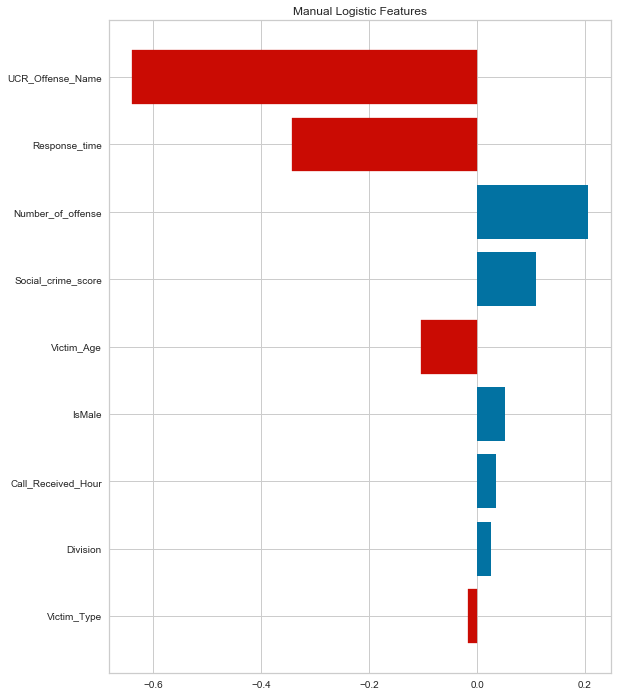

[(-0.6399969896532242, 'UCR_Offense_Name'),
 (-0.342608347337627, 'Response_time'),
 (-0.10380124662246015, 'Victim_Age'),
 (-0.01724560165276642, 'Victim_Type'),
 (0.026024958906345267, 'Division'),
 (0.03586939320939996, 'Call_Received_Hour'),
 (0.05141882762706277, 'IsMale'),
 (0.10958347792129841, 'Social_crime_score'),
 (0.20606521657154311, 'Number_of_offense')]

In [84]:
plotCoef(regGridSearch.best_estimator_.coef_[0], inci_X.columns.values, "Manual Logistic Features")
list(sorted(zip(regGridSearch.best_estimator_.coef_.ravel(), inci_X.columns.values)))

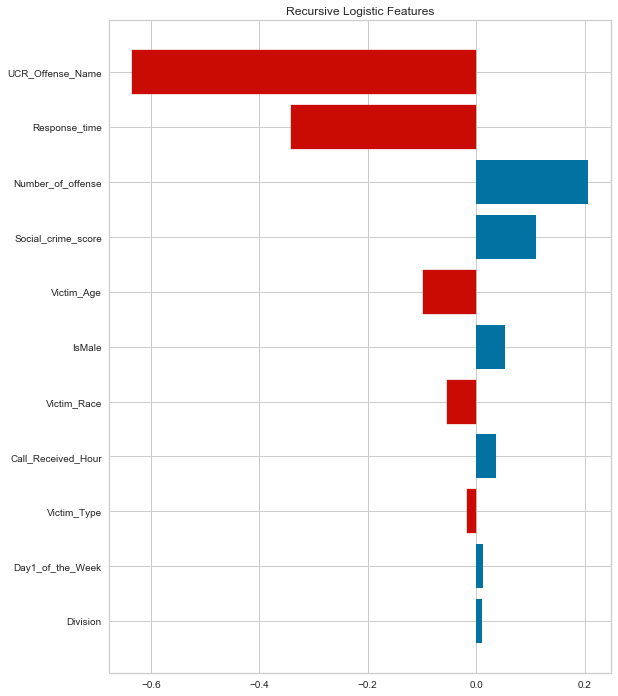

[(-0.6357403042630152, 'UCR_Offense_Name'),
 (-0.342035682836637, 'Response_time'),
 (-0.09847028899992874, 'Victim_Age'),
 (-0.053853591243530195, 'Victim_Race'),
 (-0.017736734529159373, 'Victim_Type'),
 (0.010924510060529679, 'Division'),
 (0.012205151971932022, 'Day1_of_the_Week'),
 (0.03610300601121635, 'Call_Received_Hour'),
 (0.0540398110994203, 'IsMale'),
 (0.1097155845047364, 'Social_crime_score'),
 (0.20676061195918596, 'Number_of_offense')]

In [85]:
plotCoef(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values, "Recursive Logistic Features")
list(sorted(zip(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values)))

## Interpreting Support Vectors

For SVM models, the interpretation of field importance is not as straight forward. Non-linear SVM models create hyperplanes in infinite dimensional space. To accomplish this the source data used in the analysis must be mapped to a higher dimensional space and as a result is very different from the original data. Because of this it is not possible to determine feature weights like we did with the logisitc regessions above.

However, we can examine individual features to investigate how SVM approaches classification problems.In the case below, we are vizualizing decision boundaries of two features i.e UCR_Offense_Name and Division.

Text(0.5,1,'SVM Decision Region Boundary')

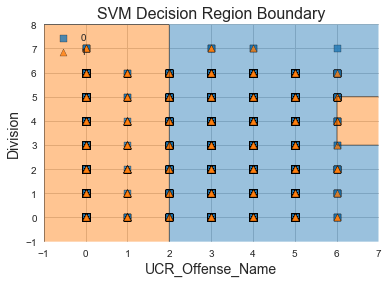

In [86]:
from sklearn import svm
from mlxtend.plotting import plot_decision_regions

# Fit Support Vector Machine Classifier
X = inci_X_SVM[['UCR_Offense_Name', 'Division']]
y = inci_Y

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X.values, y.values) 

# Plot Decision Region using mlxtend's awesome plotting function
plot_decision_regions(X=X.values, 
                      y=y.values,
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel(X.columns[0], size=14)
plt.ylabel(X.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=16)

# Area Under Curve- Receiver Operating Characteristics(AUC-ROC Curve) 
 
To visualize the performance of our classification problem, below are the AUC-ROC curve for  logistic regression.

### Logistic Regression AUC-ROC Curve

In [88]:
from sklearn.model_selection import train_test_split

# Extract the numpy arrays from the data frame
X = df_inci_X_scaled.as_matrix()
y = inci_Y.as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

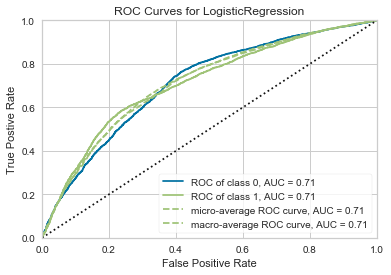

In [89]:
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ROCAUC

# Instantiate the classification model and visualizer
logistic = LogisticRegression()
visualizer = ROCAUC(logistic)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In the **Receiver Operating Characteristic** (ROC) curve, we plot the True Positive Rate (Sensitivity) against the False Positive Rate (Specificity) for different cut-off points. Classifiers that give curves closer to the top-left corner indicate a better performance. 

As we can see in the above plot, the ROC curve has a nice shape indicating that the model is better at discriminating between the positives and negatives.

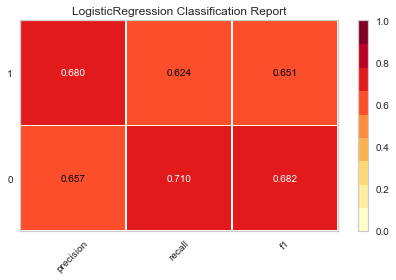

In [90]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
viz = ClassificationReport(LogisticRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

#### Logistic Regression Classification Report Interpretation

The Logistic Regression model has a precision of 0.68 for class 1 (Arrest) and 0.657 for Class 0 (No Arrest). Precision is the ability of the classifier not to label as positive a sample that is negative.

The model has a recall of 0.624 for class 1 (Arrest) and 0.71 for Class 0 (No Arrest). Recall is the ability of the classifier to find all the positive samples.

The model has a F-score of 0.651 for class 1 (Arrest) and 0.682 for Class 0 (No Arrest). F-Score is teh weighted harmonic mean of the precision and recall.

# SVM

In [91]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create classification dataset
X= df_inci_X_SVM_scaled
Y = inci_Y

# classes = ["ARRESTED", "NOT ARRESTED"]
# Perform 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,
                                                    random_state=42)

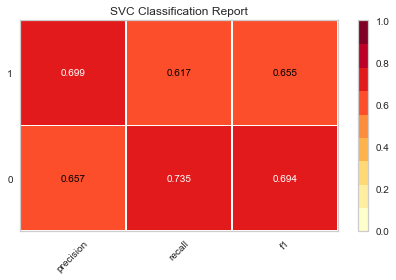

In [92]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
# from sklearn.linear_model import SVC
from sklearn.svm import SVC
viz = ClassificationReport(SVC())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

#### Support Vector Machines Classification Report Interpretation

The SVM model has a precision of 0.699 for class 1 (Arrest) and 0.657 for Class 0 (No Arrest).

The model has a recall of 0.617 for class 1 (Arrest) and 0.735 for Class 0 (No Arrest).

The model has a F-score of 0.655 for class 1 (Arrest) and 0.694 for Class 0 (No Arrest).

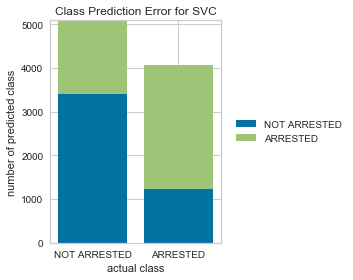

In [93]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVC(), classes=["NOT ARRESTED","ARRESTED"]
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
g = visualizer.poof()

# Conclusion

In this project, we found out that the "GridSearchCV Logistic Regression with Manual Feature reduction" model and "GridSearchCV Logistic Regression with RFE" produced the better accuracy and recall. SVM was marginally better with precision base on our police incident dataset. We were able to use these 3 models sucessfully made the prediction on the arrest maken for the police incident call. This gave us a good fundation for our next project on the model evaluation.

###### Key References

\[1\] Logistic Regression, SVMs, and Gradient Optimization,  By Eric Eclarson Github Feb 22, 2017. Github \[Online\]. Available: https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb.

\[2\] Predicting Highly Segregated Public High Schools, By Jake Drew June 11, 2018. Github \[Online\]. Available: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb (Logit).

\[3\] Support Vector Machines vs Logistic Regression, By Kevin Swersky, University of Toronto CSC2515 Tutorial \[Online\]. Available:  http://www.cs.toronto.edu/~kswersky/wp-content/uploads/svm_vs_lr.pdf

\[4\] Plot SVM with Matplotlib? By Max Power Apr 8, 2014, Stack Overflow, \[Online\]. Available: https://stackoverflow.com/questions/43284811/plot-svm-with-matplotlib

### END OF REPORT